# Strategies to prevent overfitting in neural networks

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

try:
    tf.set_random_seed(1337)                    # set the random seed for reproducibility
except:
    tf.random.set_seed(1337)                     # NOTE: Newer version of tensorflow uses tf.random.set_seed
np.random.seed(1337)                         #       instead of tf.set_random_seed

## Introduction

**Business Context.** You are a data scientist working for a machine learning consultancy. One of your clients wants to be able to classify text reviews automatically by the likely rating (on a 1 - 5 scale) that that person would give. However, they do not have sufficient data they generated on their own to do this, so you need to use an external, rich dataset as a basis on which to build your model and then translate it over.

**Business Problem.** Your task is to **build a neural networks-based model for classifying text reviews into likely ratings (on a 1 - 5 scale)**.

**Analytical Context.** We'll use the Amazon review dataset again and try to classify reviews into star ratings automatically. Instead of just positive and negative, we'll take on the harder challenge of predicting the *exact* star rating. The lowest score is 1 and the highest is 5.

Instead of trying to optimize by pre-processing the text, we'll do very basic tokenization and experiment with different neural network models, architectures, and hyperparameters to optimize the results. You'll start by building a simple dense neural network and try to get it to perform better using various techniques. Then you'll evaluate the results and diagnose where it tends to perform more poorly.

## Setting up and preparing the data

We'll mainly be using the `keras` module from TensorFlow, but we'll also use `pandas` to read the CSV file and `sklearn` for some helper functions. We'll be using only the "Text" and "Score" columns in the `Reviews.csv` file:

In [2]:
amazon_reviews = pd.read_csv('Reviews.csv', nrows=262084)
amazon_reviews.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Exercise 1:

Combine the first 1,000 of each of the 1-, 2-, 3-, 4-, and 5-star reviews in `amazon_reviews` into a single DataFrame (so you should have 5,000 observations in total). Split this DataFrame into training and test sets, with 80% of the data for the training set.

**Hint:** `keras` will expected your labels to start with 0, and not 1, so make sure to adjust the labels accordingly.

**Answer.**

In [3]:
amazon=pd.DataFrame()
for scores in range(1,6):
    amazon=pd.concat([amazon,amazon_reviews[amazon_reviews['Score']==scores].head(1000)])
amazon=amazon.reset_index(drop='True')
amazon['Score']=amazon['Score']-1

In [4]:
# Import stopwords with nltk.
from nltk.corpus import stopwords
stop = stopwords.words('english')


# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
amazon['text_no_stopwords'] = amazon['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_no_stopwords
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanuts.....
1,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,My cats happily eating Felidae Platinum two ye...
2,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...","The candy red , No flavor . Just plan chewy . ..."
3,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...","This oatmeal good. Its mushy, soft, I like it...."
4,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,0,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,Arrived 6 days stale could eat 6 bags!!


In [10]:
##Taking out special characters
import re

amazon.text_no_stopwords = amazon.text_no_stopwords.apply(
    lambda x: re.sub('[^A-Za-z0-9 ]+', ' ', x)
)
amazon.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,text_no_stopwords
0,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Product arrived labeled Jumbo Salted Peanuts t...
1,13,B0009XLVG0,A327PCT23YH90,LT,1,1,0,1339545600,My Cats Are Not Fans of the New Food,My cats have been happily eating Felidae Plati...,My cats happily eating Felidae Platinum two ye...
2,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,0,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",The candy red No flavor Just plan chewy ...
3,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,0,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d...",This oatmeal good Its mushy soft I like it ...
4,63,B001EO5TPM,A1E09XGZUR78C6,gary sturrock,2,2,0,1215302400,stale product.,Arrived in 6 days and were so stale i could no...,Arrived 6 days stale could eat 6 bags


In [5]:
y = amazon.Score
X = amazon.text_no_stopwords
X_train_no_stopwords, X_test_no_stopwords, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [6]:
y = amazon.Score
X = amazon.Text
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

------------

## Tokenizing our texts

Keras comes with its own functions to preprocess text, including a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer) (a mapping from each word in our corpus to a unique integer). Unlike the `CountVectorizer` from `sklearn`, which produces sparse matrices, `keras` often expects to work with sequences representing only the words that occur in a text. To prepare text before feeding it into a neural network, we usually:

1. Create a [tokenizer](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer).
2. [Create sequences](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer#texts_to_sequences) from our text (each text becomes a list of integers, based on the tokenizer mapping, instead of words)
3. [Pad or truncate](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences) each sequence to a fixed length (very short texts get `0`s added to them, while very long ones are truncated).

The tokenizer has a configurable word cap, so it will only consider the $n$ most common words in the corpus, ignoring very rare words.

### Exercise 2:

In this exercise, you will learn how to use the `tf.keras.preprocessing.text.Tokenizer` tool to carry out the preprocessing steps described above.

#### 2.1

Perform some exploratory analysis of the dataset to calculate the number of unique words in our corpus and the distribution of the number of words in each review of the training set. What is the 80th percentile of this distribution?

**Answer.**

In [29]:
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
tokens=list(tokenizer.word_index)
print("Number of unique tokens then: ", len(set(tokens)))
print("80% of unique tokens: ", len(set(tokens))*0.8)

Number of unique tokens then:  13233
80% of unique tokens:  10586.400000000001


In [35]:
import nltk
Num_words=X_train.apply(lambda x: len(nltk.word_tokenize(x)))

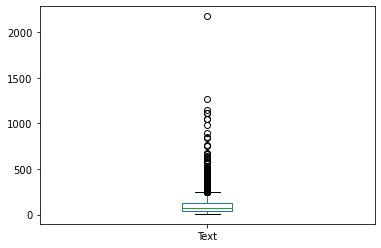

In [36]:
Num_words.plot.box()

In [37]:
print("80 percentile for the number of word's distribution= ",np.percentile(Num_words,80))

80 percentile for the number of word's distribution=  141.0


------------

#### 2.2

Given the results above, we create a tokenizer using only the top 20,000 most frequent words in our corpus (which corresponds to roughly 80% of the words): 

In [7]:
tokenizer = Tokenizer(num_words=20000) #We create the tokenizer using only top 20000 words

In [8]:
tokenizer.fit_on_texts(X_train)  #Then, we create the text->indices mapping. 

In [65]:
tokenizer.word_index

{'the': 1,
 'i': 2,
 'a': 3,
 'and': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'br': 8,
 'is': 9,
 'this': 10,
 'in': 11,
 'for': 12,
 'but': 13,
 'that': 14,
 'not': 15,
 'my': 16,
 'was': 17,
 'with': 18,
 'you': 19,
 'have': 20,
 'are': 21,
 'they': 22,
 'as': 23,
 'like': 24,
 'on': 25,
 'so': 26,
 'these': 27,
 'be': 28,
 'taste': 29,
 'good': 30,
 'if': 31,
 'product': 32,
 'them': 33,
 'coffee': 34,
 'or': 35,
 'just': 36,
 'at': 37,
 'very': 38,
 'all': 39,
 'one': 40,
 'flavor': 41,
 "it's": 42,
 'would': 43,
 'had': 44,
 'from': 45,
 'can': 46,
 'more': 47,
 'me': 48,
 'when': 49,
 'no': 50,
 'has': 51,
 'than': 52,
 'will': 53,
 'other': 54,
 'out': 55,
 'we': 56,
 'great': 57,
 'were': 58,
 'much': 59,
 'too': 60,
 'some': 61,
 "don't": 62,
 'really': 63,
 'up': 64,
 'because': 65,
 'there': 66,
 'tea': 67,
 'only': 68,
 'get': 69,
 'about': 70,
 'chips': 71,
 'an': 72,
 'amazon': 73,
 'food': 74,
 'better': 75,
 'what': 76,
 'buy': 77,
 'your': 78,
 'love': 79,
 'which': 80,
 'sug

The above line has given several features and methods to our tokenizer. For instance, print the line `tokenizer.word_index` in a new cell - what do you see? Apply the `tokenizer.texts_to_sequences()` method on the list `['I just feel very very good']`. Apply the `tokenizer.sequences_to_texts()` method on the list `[[109, 19, 824, 76, 114, 6315, 1137, 8070]]`. What were your results?

**Answer.**

------------

In [30]:
tokenizer.texts_to_sequences(['I just feel very very good'])

[[2, 36, 362, 38, 38, 30]]

In [31]:
tokenizer.sequences_to_texts([[109, 19, 824, 76, 114, 6315, 1137, 8070]])

['bag you o what sweet organically cases clash']

#### 2.3

Use the tokenizer to transform the texts in our test and train data to sequences. Then, use the `pad_sequences` function to pad/truncate these sequences to length 116 (the 80th percentile of text lengths). Save the resulting arrays as `train_sequences` and `test_sequences`.

**Answer.**

In [9]:
train_sequences=X_train.apply(lambda x: tokenizer.texts_to_sequences([x]) )
train_sequences=train_sequences.apply(lambda x: pad_sequences(x,maxlen=116) )
tmp = [row.reshape(-1,1) for row in train_sequences.values]
train_sequences = np.concatenate(tmp, axis=1).T
train_sequences

array([[   0,    0,    0, ...,    3,  191,  297],
       [   0,    0,    0, ..., 1641,  176,   60],
       [   0,    0,    0, ..., 1245,  320,   34],
       ...,
       [   9,   23,  127, ...,    5,  246,    6],
       [  27,   71,   21, ...,    7,    1,  109],
       [   0,    0,    0, ...,   12,  739, 1352]])

In [10]:
test_sequences=X_test.apply(lambda x: tokenizer.texts_to_sequences([x]) )
test_sequences=test_sequences.apply(lambda x: pad_sequences(x,maxlen=116) )
tmp = [row.reshape(-1,1) for row in test_sequences.values]
test_sequences = np.concatenate(tmp, axis=1).T
test_sequences

array([[   0,    0,    0, ...,   25, 1009,   85],
       [   0,    0,    0, ...,    5,    1,  174],
       [   0,    0,    0, ...,   10,   83, 1491],
       ...,
       [ 357,  507,  568, ...,    1, 1280,  380],
       [   0,    0,    0, ...,  124,    2,  440],
       [   0,    0,    0, ..., 3357,    1,  781]])

In [11]:
labels=y_train

------------

## Building a basic neural network model 

Now that we have preprocessed the text, let's create a basic neural network to train on our data. We'll use an embedding layer which performs [one-hot encoding](https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/) on our word sequences, two fully connected ("dense") layers, and an output layer with 5 neurons to represent the 5 possible star ratings.

Before we train a `keras` model, there is an additional `compile` step where we define what loss function and optimizer to use, and what metrics to output. Then we can train the model using the `fit` function. All of this is shown below.

Note the `validation_split=0.2` argument which tells Keras to train on only 80% of the training data and tune the model on the remaining 20%, which we call the validation set. You can see the accuracy and loss for both the training and validation set in the output for each epoch:

In [32]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 116, 128)          2560000   
_________________________________________________________________
dense (Dense)                (None, 116, 128)          16512     
_________________________________________________________________
dense_1 (Dense)              (None, 116, 128)          16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 2,593,669
Trainable params: 2,593,669
Non-trainable params: 0
_________________________________________________________________


In [33]:
history=model.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 5s 51ms/step - loss: 1.5840 - accuracy: 0.2716 - val_loss: 1.5155 - val_accuracy: 0.3525
Epoch 2/10
100/100 [==============================] - 5s 48ms/step - loss: 1.3578 - accuracy: 0.4444 - val_loss: 1.3179 - val_accuracy: 0.4437
Epoch 3/10
100/100 [==============================] - 5s 49ms/step - loss: 1.0198 - accuracy: 0.6119 - val_loss: 1.2707 - val_accuracy: 0.4563
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.6973 - accuracy: 0.7619 - val_loss: 1.3843 - val_accuracy: 0.4600
Epoch 5/10
100/100 [==============================] - 5s 49ms/step - loss: 0.4164 - accuracy: 0.8797 - val_loss: 1.4960 - val_accuracy: 0.4588
Epoch 6/10
100/100 [==============================] - 5s 48ms/step - loss: 0.2259 - accuracy: 0.9519 - val_loss: 1.7028 - val_accuracy: 0.4500
Epoch 7/10
100/100 [==============================] - 5s 51ms/step - loss: 0.1087 - accuracy: 0.9859 - val_loss: 1.8758 - val_accuracy: 0.4462

### Exercise 3:

How well does this model perform? How does this compare to a baseline expectation? What do you notice about the accuracy and loss values for both the validation and training sets over time and what does this mean?

**Answer.**

In [30]:
# Plot history: MSE
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'], label='ACC (training data)')
    plt.plot(history.history['val_accuracy'], label='ACC (validation data)')
    plt.title('ACC')
    plt.ylabel('ACC value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    plt.figure()
    # Plot history: MAE
    plt.plot(history.history['loss'], label='MAE (training data)')
    plt.plot(history.history['val_loss'], label='MAE (validation data)')
    plt.title('MAE')
    plt.ylabel('MAE value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

------------

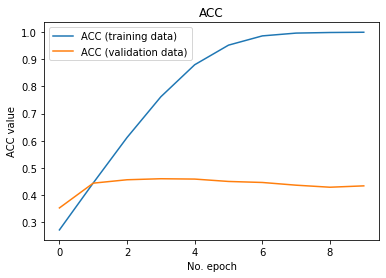

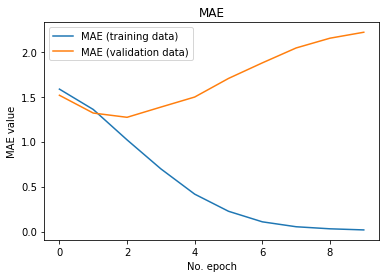

In [34]:
plot_history(history)

Our algorithm has an incredible performance in the training stage, but when doing the validation we find that it does not have good results, that this model is even worse than making the decision by throwing a coin

## Experimenting with different regularization strategies

There are many different ways to mitigate overfitting in a neural network, collectively known as *regularization* techniques. One common regularization technique is called [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout). In this regularization method, a set of neurons is randomly selected at each training step to be completely ignored. This is done so that the neurons in our network do not rely strongly on their neighboring neurons and we avoid the creation of ["co-adaptations"](http://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) that do not generalize well to unseen data. This making the model more robust and less prone to overffiting.

You can create dropouts in `keras` by adding a layer named `Dropout(p)`, where `p` is the probability of dropping neurons in the previous layer. For example, the following model would implement dropout by removing roughly 20% percent of the outputs of the embedding layer at each training step:

In [35]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu')) 
model2.add(Dense(128, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 6s 59ms/step - loss: 1.5923 - accuracy: 0.2422 - val_loss: 1.5441 - val_accuracy: 0.3325
Epoch 2/10
100/100 [==============================] - 6s 58ms/step - loss: 1.4439 - accuracy: 0.3837 - val_loss: 1.3562 - val_accuracy: 0.4375
Epoch 3/10
100/100 [==============================] - 6s 58ms/step - loss: 1.1782 - accuracy: 0.5141 - val_loss: 1.2787 - val_accuracy: 0.4663
Epoch 4/10
100/100 [==============================] - 5s 55ms/step - loss: 0.9128 - accuracy: 0.6491 - val_loss: 1.3051 - val_accuracy: 0.4712
Epoch 5/10
100/100 [==============================] - 6s 55ms/step - loss: 0.6473 - accuracy: 0.7881 - val_loss: 1.3795 - val_accuracy: 0.4750
Epoch 6/10
100/100 [==============================] - 6s 55ms/step - loss: 0.4300 - accuracy: 0.8716 - val_loss: 1.5225 - val_accuracy: 0.4737
Epoch 7/10
100/100 [==============================] - 6s 56ms/step - loss: 0.2552 - accuracy: 0.9391 - val_loss: 1.7227 - val_accuracy: 0.4663

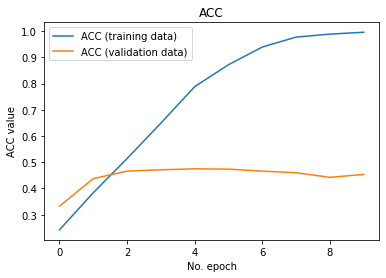

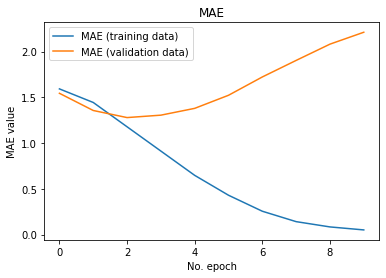

In [36]:
plot_history(history)

### Exercise 4:

Modify the neural network definition above to try and fix the overfitting problem using Dropout. Explain the configuration that you tried and your results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

In [29]:
accuracy_p=[]
for val in [0.1,0.2,0.3,0.4,0.5]:
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
    model2 = Sequential()
    model2.add(Embedding(20000, 128, input_length=116))
   # model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
    model2.add(Dense(128, activation='relu')) 
   # model2.add(Dropout(val)) # --------------------------->Dropout layer will affect the output of previous layer.
    model2.add(Dense(128, activation='relu'))
    model2.add(Dropout(val)) # --------------------------->Dropout layer will affect the output of previous layer.
    model2.add(GlobalMaxPooling1D())
    model2.add(Dense(5, activation='sigmoid'))
    model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10,callbacks=[callback])
    accuracy_p+=[max(history.history['val_accuracy'])]
accuracy_p

Epoch 1/10
100/100 [==============================] - 8s 78ms/step - loss: 1.5891 - accuracy: 0.2466 - val_loss: 1.5366 - val_accuracy: 0.3162
Epoch 2/10
100/100 [==============================] - 7s 69ms/step - loss: 1.3998 - accuracy: 0.4116 - val_loss: 1.3696 - val_accuracy: 0.4050
Epoch 3/10
100/100 [==============================] - 6s 63ms/step - loss: 1.0798 - accuracy: 0.5713 - val_loss: 1.2890 - val_accuracy: 0.4387
Epoch 4/10
100/100 [==============================] - 7s 69ms/step - loss: 0.7670 - accuracy: 0.7212 - val_loss: 1.3634 - val_accuracy: 0.4450
Epoch 5/10
100/100 [==============================] - 7s 65ms/step - loss: 0.4807 - accuracy: 0.8503 - val_loss: 1.4799 - val_accuracy: 0.4450
Epoch 1/10
100/100 [==============================] - 7s 67ms/step - loss: 1.5825 - accuracy: 0.2675 - val_loss: 1.5312 - val_accuracy: 0.3088
Epoch 2/10
100/100 [==============================] - 7s 66ms/step - loss: 1.3837 - accuracy: 0.4241 - val_loss: 1.3364 - val_accuracy: 0.4450

[0.4449999928474426,
 0.47999998927116394,
 0.4662500023841858,
 0.4637500047683716,
 0.44624999165534973]

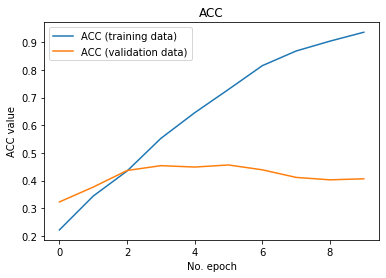

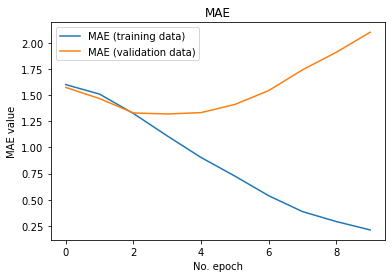

In [38]:
plot_history(history)

We use dropout in each of the neural network layers to try to reduce the overfitting problem, but it seems that our network still has this problem. Probably the amount of data is not enough to get a good classification.

Different combinations of dropouts were tested in different layers and with different values, the best result for the accuracy in the validation group was obtained using only a dropout in any layer with a value of 0.2

------------

### Exercise 5:

Keras allows you to add [L1](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1), [L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l2), or [L1 and L2](https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/l1_l2) combined regularizers on individual layers by passing in the `kernel_regularizer`, `bias_regularizer` or `activity_regularizer` arguments. In neural networks, these regularizers work by penalizing the loss function in different ways, based on the number of weights or the size of the weights.

Try 4-5 different combinations of L1, L2, L1 and L2 regularization in different combinations on different layers. In each example, explain why you tried that configuration and the results. Why do you think your modifications were or were not able to mitigate the overfitting problem?

**Answer.**

In [42]:

model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.0001),activity_regularizer=regularizers.l1(0.001))) 
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 67ms/step - loss: 1.7397 - accuracy: 0.2166 - val_loss: 1.6828 - val_accuracy: 0.2875
Epoch 2/10
100/100 [==============================] - 7s 66ms/step - loss: 1.6059 - accuracy: 0.3184 - val_loss: 1.5530 - val_accuracy: 0.3137
Epoch 3/10
100/100 [==============================] - 7s 69ms/step - loss: 1.4428 - accuracy: 0.3794 - val_loss: 1.5046 - val_accuracy: 0.3350
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 1.2823 - accuracy: 0.4750 - val_loss: 1.5126 - val_accuracy: 0.3775
Epoch 5/10
100/100 [==============================] - 6s 64ms/step - loss: 1.1309 - accuracy: 0.5487 - val_loss: 1.5781 - val_accuracy: 0.3650
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.9478 - accuracy: 0.6400 - val_loss: 1.7728 - val_accuracy: 0.3512
Epoch 7/10
100/100 [==============================] - 6s 65ms/step - loss: 0.7851 - accuracy: 0.7291 - val_loss: 2.0392 - val_accuracy: 0.3487

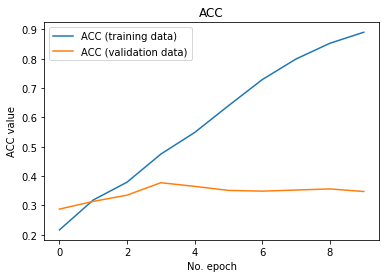

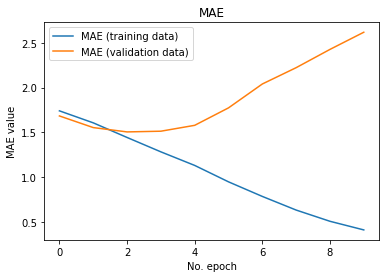

In [43]:
plot_history(history)

In [44]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001),activity_regularizer=regularizers.l2(0.001))) 
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 66ms/step - loss: 1.6310 - accuracy: 0.2138 - val_loss: 1.6086 - val_accuracy: 0.2900
Epoch 2/10
100/100 [==============================] - 6s 64ms/step - loss: 1.5366 - accuracy: 0.3378 - val_loss: 1.4954 - val_accuracy: 0.3775
Epoch 3/10
100/100 [==============================] - 7s 66ms/step - loss: 1.3503 - accuracy: 0.4431 - val_loss: 1.3881 - val_accuracy: 0.4338
Epoch 4/10
100/100 [==============================] - 6s 64ms/step - loss: 1.1577 - accuracy: 0.5422 - val_loss: 1.4254 - val_accuracy: 0.4087
Epoch 5/10
100/100 [==============================] - 6s 65ms/step - loss: 0.9820 - accuracy: 0.6247 - val_loss: 1.4844 - val_accuracy: 0.4050
Epoch 6/10
100/100 [==============================] - 6s 65ms/step - loss: 0.8026 - accuracy: 0.7150 - val_loss: 1.5734 - val_accuracy: 0.4062
Epoch 7/10
100/100 [==============================] - 6s 64ms/step - loss: 0.6142 - accuracy: 0.8000 - val_loss: 1.7858 - val_accuracy: 0.3887

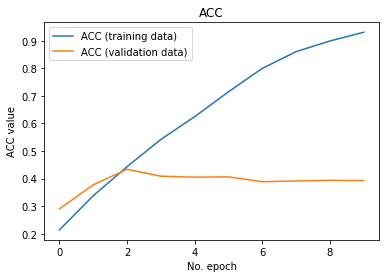

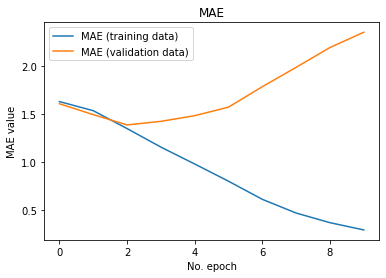

In [45]:
plot_history(history)

In [34]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l1(0.001))) 
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 67ms/step - loss: 1.6106 - accuracy: 0.2550 - val_loss: 1.5580 - val_accuracy: 0.3288
Epoch 2/10
100/100 [==============================] - 6s 64ms/step - loss: 1.4454 - accuracy: 0.3994 - val_loss: 1.4206 - val_accuracy: 0.3988
Epoch 3/10
100/100 [==============================] - 7s 65ms/step - loss: 1.1720 - accuracy: 0.5334 - val_loss: 1.3308 - val_accuracy: 0.4500
Epoch 4/10
100/100 [==============================] - 6s 63ms/step - loss: 0.9060 - accuracy: 0.6741 - val_loss: 1.3993 - val_accuracy: 0.4313
Epoch 5/10
100/100 [==============================] - 7s 66ms/step - loss: 0.6416 - accuracy: 0.7941 - val_loss: 1.5186 - val_accuracy: 0.4288
Epoch 6/10
100/100 [==============================] - 6s 64ms/step - loss: 0.4175 - accuracy: 0.8838 - val_loss: 1.7504 - val_accuracy: 0.4150
Epoch 7/10
100/100 [==============================] - 6s 64ms/step - loss: 0.2701 - accuracy: 0.9459 - val_loss: 1.9596 - val_accuracy: 0.4175

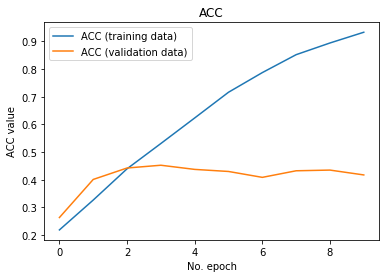

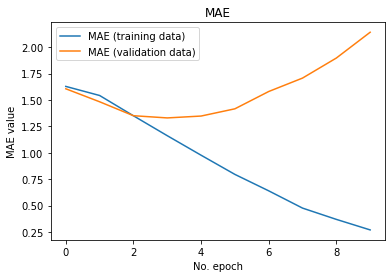

In [47]:
plot_history(history)

In [33]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001),bias_regularizer=regularizers.l1(0.001))) 
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l1(1e-4)))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 75ms/step - loss: 1.7051 - accuracy: 0.2394 - val_loss: 1.6565 - val_accuracy: 0.2738
Epoch 2/10
100/100 [==============================] - 7s 68ms/step - loss: 1.5435 - accuracy: 0.3791 - val_loss: 1.4785 - val_accuracy: 0.4000
Epoch 3/10
100/100 [==============================] - 6s 63ms/step - loss: 1.2921 - accuracy: 0.4913 - val_loss: 1.3861 - val_accuracy: 0.4275
Epoch 4/10
100/100 [==============================] - 6s 64ms/step - loss: 1.0337 - accuracy: 0.6256 - val_loss: 1.4727 - val_accuracy: 0.4275
Epoch 5/10
100/100 [==============================] - 6s 62ms/step - loss: 0.7986 - accuracy: 0.7369 - val_loss: 1.6151 - val_accuracy: 0.4175
Epoch 6/10
100/100 [==============================] - 6s 65ms/step - loss: 0.5884 - accuracy: 0.8369 - val_loss: 1.8193 - val_accuracy: 0.4238
Epoch 7/10
100/100 [==============================] - 6s 65ms/step - loss: 0.4176 - accuracy: 0.9013 - val_loss: 2.1130 - val_accuracy: 0.4050

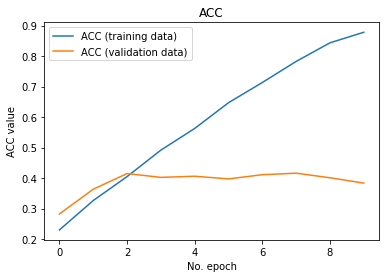

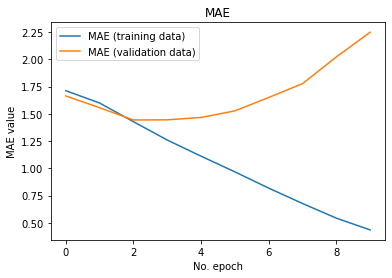

In [49]:
plot_history(history)

In [32]:
model2 = Sequential()
model2.add(Embedding(20000, 128, input_length=116))
model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001))) 
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(Dense(128, activation='relu',kernel_regularizer=regularizers.l2(1e-4)))
#model2.add(Dropout(0.2)) # --------------------------->Dropout layer will affect the output of previous layer.
model2.add(GlobalMaxPooling1D())
model2.add(Dense(5, activation='sigmoid'))
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model2.fit(train_sequences, labels, validation_split=0.2, epochs=10)

Epoch 1/10
100/100 [==============================] - 7s 74ms/step - loss: 1.6232 - accuracy: 0.2322 - val_loss: 1.5845 - val_accuracy: 0.3013
Epoch 2/10
100/100 [==============================] - 7s 69ms/step - loss: 1.5119 - accuracy: 0.3512 - val_loss: 1.4410 - val_accuracy: 0.3900
Epoch 3/10
100/100 [==============================] - 6s 65ms/step - loss: 1.2793 - accuracy: 0.4725 - val_loss: 1.3466 - val_accuracy: 0.4412
Epoch 4/10
100/100 [==============================] - 7s 66ms/step - loss: 1.0322 - accuracy: 0.6006 - val_loss: 1.3844 - val_accuracy: 0.4462
Epoch 5/10
100/100 [==============================] - 6s 64ms/step - loss: 0.7928 - accuracy: 0.7237 - val_loss: 1.4305 - val_accuracy: 0.4525
Epoch 6/10
100/100 [==============================] - 7s 67ms/step - loss: 0.5748 - accuracy: 0.8184 - val_loss: 1.5760 - val_accuracy: 0.4500
Epoch 7/10
100/100 [==============================] - 7s 65ms/step - loss: 0.3949 - accuracy: 0.8997 - val_loss: 1.7429 - val_accuracy: 0.4338

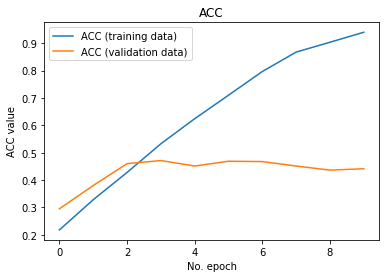

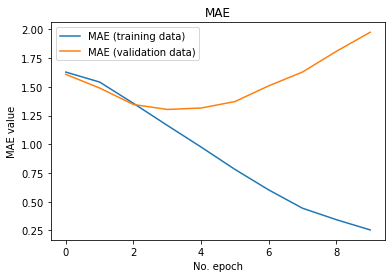

In [51]:
plot_history(history)

------------

## Regularization through adding more data

Depending on the configurations you tried above, you probably saw that L1 and L2 regularization are pretty limited for this model and this amount of data. A more straightforward way to prevent overfitting is simply by adding more training data. If the network has more (and more varied) examples to learn from, perhaps it will learn more generalizable rules.

### Exercise 6:

How would you test the hypothesis that adding more data would result in a more generalizable model? Explain any change in results you see from further experimentation.

**Hint:** Try adding 6000 reviews for each score instead. Compare with the original proposed model.

**Answer.**

In [72]:
amazon2=pd.DataFrame()
for scores in range(1,6):
    amazon2=pd.concat([amazon2,amazon_reviews[amazon_reviews['Score']==scores].head(6000)])
amazon2=amazon2.reset_index(drop='True')

y = amazon2.Score
X = amazon2.Text
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=40)

tokenizer2 = Tokenizer(num_words=20000) 
tokenizer2.fit_on_texts(X_train2)
labels2=y_train2-1

train_sequences2 = tokenizer2.texts_to_sequences(X_train2)
test_sequences2 = tokenizer2.texts_to_sequences(X_test2)

train_sequences2 = pad_sequences(train_sequences2, maxlen= 116)
test_sequences2 = pad_sequences(test_sequences2, maxlen= 116)





In [73]:
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_sequences2, labels2, validation_split=0.2, epochs=10)

Epoch 1/10
600/600 [==============================] - 36s 59ms/step - loss: 1.3624 - accuracy: 0.4020 - val_loss: 1.2428 - val_accuracy: 0.4613
Epoch 2/10
600/600 [==============================] - 40s 66ms/step - loss: 1.1314 - accuracy: 0.5179 - val_loss: 1.2090 - val_accuracy: 0.4835
Epoch 3/10
600/600 [==============================] - 39s 65ms/step - loss: 0.9716 - accuracy: 0.6011 - val_loss: 1.2244 - val_accuracy: 0.5013
Epoch 4/10
600/600 [==============================] - 37s 62ms/step - loss: 0.8116 - accuracy: 0.6783 - val_loss: 1.2853 - val_accuracy: 0.4981
Epoch 5/10
600/600 [==============================] - 40s 67ms/step - loss: 0.6610 - accuracy: 0.7482 - val_loss: 1.4531 - val_accuracy: 0.4919
Epoch 6/10
600/600 [==============================] - 40s 67ms/step - loss: 0.5246 - accuracy: 0.8080 - val_loss: 1.5719 - val_accuracy: 0.4960
Epoch 7/10
600/600 [==============================] - 39s 66ms/step - loss: 0.4074 - accuracy: 0.8535 - val_loss: 1.7654 - val_accuracy:

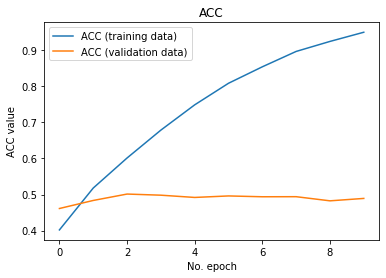

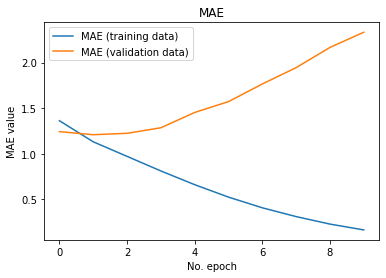

In [74]:
plot_history(history)

------------

## Regularization through early stopping

We have consistently seen that our neural network overfits at around the third epoch. Hence, another form of regularization is to end training early if validation loss starts increasing. (This is similar to the validation curves we used when constructing classification models.) Although the network will not have found an optimal function in the training data, the looser function that it has found will likely be more generalizable.

You can do this manually by inspecting the data as we have done above and modifying the `epochs` argument in `fit()`, but Keras also allows you to easily do this automatically via an [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

### Exercise 7:

Experiment with the `EarlyStopping` callback and explain the results.

**Answer.**

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model = Sequential()
model.add(Embedding(20000, 128, input_length=116))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_sequences2, labels2, validation_split=0.2, epochs=10, callbacks=[callback])

Epoch 1/10
600/600 [==============================] - 40s 67ms/step - loss: 1.3811 - accuracy: 0.3826 - val_loss: 1.2378 - val_accuracy: 0.4708
Epoch 2/10
600/600 [==============================] - 35s 59ms/step - loss: 1.1261 - accuracy: 0.5274 - val_loss: 1.2056 - val_accuracy: 0.4842
Epoch 3/10
600/600 [==============================] - 35s 58ms/step - loss: 0.9611 - accuracy: 0.6093 - val_loss: 1.2143 - val_accuracy: 0.5038
Epoch 4/10
600/600 [==============================] - 31s 52ms/step - loss: 0.8060 - accuracy: 0.6818 - val_loss: 1.2925 - val_accuracy: 0.5015


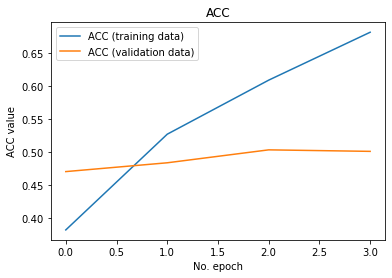

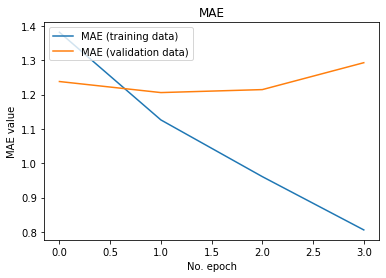

In [80]:
plot_history(history)

------------

## Evaluating our model

Unlike in most previous cases, we used *three* splits of our data instead of two. All of our model tuning has been done on the validation set, and we have not even touched the test set that we split off right at the start.

For experiments, it's very important that your model is only run **once** on your test set. As there is so much randomness at play, it's vital to not "cherry-pick" the best results, so optimize as much as you want on the validation set, but keep the test set until the end and all official results should be based on the single run of the test set (or whatever configuration was decided *before the experiment started*).

### Exercise 8:

Let's take the model configuration that resulted in the highest validation accuracy and use that one as our final model. Evaluate this configuration on how well it performs on the test set, and furthermore diagnose *what kinds of mistakes it makes*. Explain whether these mistakes are expected or not, and print some of these poorly classified reviews. Given the mistakes the model made, how would you then go back and try to improve the model or optimize the tuning steps?

**Hint:** You can use the [`predict_classes`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential#predict_classes) method on your model to get the most probable class directly.

**Answer.**

------------

In [136]:
predicted_model = pd.DataFrame(model.predict_classes(test_sequences2))
predicted_model[['Original_index','scores']]=y_test2.reset_index()
predicted_model.scores=predicted_model.scores-1
predicted_model

,0,Original_index,scores
0,4,28478,4
1,0,3956,0
2,1,7014,1
3,3,18659,3
4,0,15274,2
...,...,...,...
5995,0,1432,0
5996,1,10241,1
5997,4,21975,3
5998,4,29297,4


In [96]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix(predicted_model.scores, predicted_model[0])

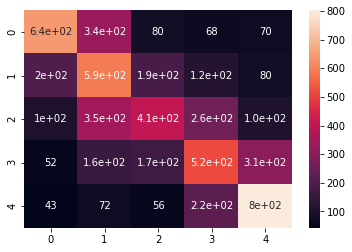

In [97]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [106]:
acc=sum(np.where(predicted_model.scores == predicted_model[0], 1, 0))*100/len(predicted_model[0])

In [108]:
print('The final model has an accuracy of', acc, '% with the test group')

The final model has an accuracy of 49.35 % with the test group


In [137]:
predicted_model['result']=np.where(predicted_model.scores == predicted_model[0], 1, 0)
bad_clasification=predicted_model[predicted_model.result==0]
bad_clasification

,0,Original_index,scores,result
4,0,15274,2,0
7,0,7222,1,0
8,4,3520,0,0
9,4,16222,2,0
12,3,14699,2,0
...,...,...,...,...
5989,3,25355,4,0
5992,0,8919,1,0
5993,2,20562,3,0
5997,4,21975,3,0


In [124]:
X_test2.reset_index().set_index('index')

,Text
index,
28478,Although the kernels may not be as large and f...
3956,My office of 4 women tried this coffee. Every ...
7014,I did not think PB2 tasted like true peanut bu...
18659,I got this at a local discount store for $6. I...
15274,I drink tea on a very regular basis. Mostly b...
...,...
1432,I have spent a lot of time in Scotland and I c...
10241,I've been hooked on NOW's spearmint tea for aw...
21975,I use this product daily and it has significan...


In [147]:
X_test2.reset_index().set_index('index').loc[list(bad_clasification.Original_index.head(5).values)]['Text'].apply(lambda x: print(x))
bad_clasification.rename(columns={0:'Prediction','scores':'Real'}).head(5)

I drink tea on a very regular basis.  Mostly blacks, but I have green, white & rooibos in my collection.  I usually drink premium loose leaf teas and brew them in either a french press or now, my new <a href="http://www.amazon.com/gp/product/B000FPN8TK">Adagio Teas 0 16-Ounce Ingenuitea Teapot</a> tea maker (I prefer the french press).  My usual favorite blacks run thirty to fifty a pound.<br /><br />When I opened the bag I was amazed at the smell...it was just as good as the berry tea at Wegman's (NE premium grocery chain).  I just made my first using the adagio ingenuiTEA brewer.  You can definitely taste the berry, but it's on the weaker side compared to Wegman's.  The tea was smooth and seems to be low in caffeine.<br /><br />I honestly don't think it's worth the MSRP of thirty eight per pound (or even the current price of thirty).  The only reason I took the risk on a pound was that, at the time I purchased, it was on sale and there was a coupon which brought it down to twelve per

,Prediction,Original_index,Real,result
4,0,15274,2,0
7,0,7222,1,0
8,4,3520,0,0
9,4,16222,2,0
12,3,14699,2,0


Based on the results in the confusion matrix, we can conclude that the model still has problems in classifying reviews with neighboring ratings.

I would use as much information as possible, it seems that this is the one that has the most impact to avoid overfitting problems, later I would start adding dropout and l1, l2 regulizers, see how the model is improved